In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline
import pdb

import re

import cPickle

In [440]:
from PIL import Image
import cv2

env = gym.make('Breakout-v0');

[2017-05-23 13:57:48,041] Making new env: Breakout-v0


In [441]:
def downsample84(s):
    s_gray = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    return np.array(Image.fromarray(s_gray).resize((84,84)))

In [442]:
from piaget import Point, Mover, MoverTracker, FramePair, Box, Categorizer
from piaget import init_env, play

In [443]:
def processState(states):
    return np.reshape(states,[210*160*3*2])

In [444]:
def initial_obs(env):
    env.reset()
    s, r, d, info = env.step(np.random.randint(0,env.action_space.n))
    s1, r1, d1, info1 = env.step(np.random.randint(0,env.action_space.n))
    #s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    #s1 = cv2.cvtColor(s1, cv2.COLOR_BGR2GRAY)
    #s2 = cv2.cvtColor(s2, cv2.COLOR_BGR2GRAY)
    
    s_list = [s, s1]

    return s_list, r1, d1, info1

In [445]:
s_list, r, d, info = initial_obs(env)
s_stack = np.dstack(s_list)
s = processState(s_stack)

s210 = np.vstack([np.reshape(s,[210*160*3*2])]).astype('float32')

In [446]:
game_id = 595873
mt_dir = 'mt/' + str(game_id) + '/'
mt_filename = mt_dir + 'mt.pkl'
with open(mt_filename) as f:
    mt = cPickle.load(f)
img_dir = mt.img_dir
mover_dirs = [img_dir + d + '/' for d in os.listdir(img_dir) if d.find('mover') == 0]

mover_disps = []
for m in mt.movers:
    traj = m.trajectory
    disp_boxes = [(t1[1]-t0[1])/(t1[0]-t0[0]) for t1, t0 in zip(traj[1:],traj[:-1])]
    disp_pts = [(b.ll + b.ur)/2 for b in disp_boxes]
    disp_unique = {d.to_tuple() for d in disp_pts}
    disp_unique_ints = [(int(d1), int(d2)) for d1, d2 in disp_unique]
    mover_disps.append(disp_unique_ints)

In [447]:
mover_prototypes = []

for mover_dir in mover_dirs:
    mover_label = int(mover_dir[mover_dir.find('mover')+5:-1])
    list_images = [mover_dir+f for f in os.listdir(mover_dir) if re.search('jpg|JPG', f)]
    mover_images = []
    for image in list_images:
        im = np.array(Image.open(image))
        mover_images.append(im)
    prototype_index = np.random.randint(len(mover_images))
    prototype = mover_images[prototype_index]
    mover_prototypes.append(prototype)

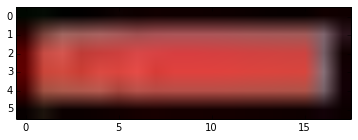

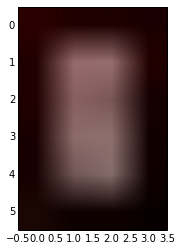

In [448]:
for p in mover_prototypes:
    plt.imshow(p)
    plt.show()

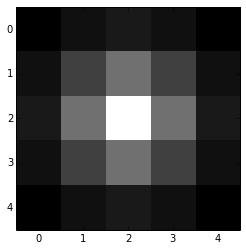

In [449]:
def local_blob(size):
    blob = np.zeros((size, size))
    middle = (size-1)/2
    for i in range(size):
        for j in range(size):
            blob[i,j] = 1./(1+((i-middle)**2 + (j-middle)**2))
    return blob
plt.imshow(local_blob(5),cmap='gray',interpolation='nearest')

### class protoQnetwork below is adapted from https://github.com/awjuliani/DeepRL-Agents

Network architecture is similar to that in the 2014 DeepMind paper.  This version uses piaget's mover images to form a first layer of convolutional filters, and their observed displacements to form the second.

In [450]:
class protoQnetwork():
    def __init__(self, h_size, mover_prototypes, mover_disps, blob_size, model_name):
        self.model_name = model_name
        self.blob_size = blob_size
        self.scalarInput =  tf.placeholder(shape=[None,210*160*3*2],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput/255.,shape=[-1,210,160,3*2])
        
        self.mover_conv_list = []
        self.disp_conv_list = []
        
        for i, proto in enumerate(mover_prototypes):
            self.mover_conv_list.append(self.get_conv_mover(proto, i))        
        
        self.conv_movers = tf.concat(self.mover_conv_list,3)
        
        for i, disps in enumerate(mover_disps):
            self.disp_conv_list.append(self.get_conv_disp(disps, i)) 
        
        self.conv_disps = tf.concat(self.disp_conv_list,3)
        
        self.conv1 = slim.conv2d( \
            inputs=self.conv_disps,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[11,8],stride=[1,1],padding='VALID', biases_initializer=None)
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.action_space.n]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.action_space.n,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.001,\
                                             epsilon=1e-3)
        self.trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                 scope='(?!' + self.model_name + 
                               '/piaget)')
        self.updateModel = self.trainer.minimize(self.loss, 
                                                 var_list=self.trainables)
    def get_conv_mover(self, proto, ind):
    
        p0 = proto/(255.)

        p0_mean = np.mean(p0,(0,1))
        p0 = p0 - p0_mean

        p0_norm = np.sqrt(np.sum(p0**2))
        p0 = p0 / p0_norm

        p0_frame0 = np.concatenate([p0, np.zeros_like(p0)],2)
        p0_frame1 = np.concatenate([np.zeros_like(p0), p0],2)

        p0_multi_frame = np.stack([p0_frame0, p0_frame1],3)

        with tf.variable_scope(self.model_name + 
                               "/piaget/prototypes/proto" + str(ind)):
            self.kernel = tf.get_variable(name='kernel',
                                        shape=p0_multi_frame.shape,
                                       initializer=tf.constant_initializer(
                                           p0_multi_frame))
            self.conv = tf.nn.conv2d(input=self.imageIn/p0_norm,
                               filter=self.kernel,
                               strides=[1,1,1,1],
                               padding='SAME'
                              )
            self.biases = tf.get_variable(name='bias',shape=(2),
                                    initializer=tf.constant_initializer(
                                        -0.75))
            self.bias = tf.nn.bias_add(self.conv, self.biases)
            self.conv_p0 = tf.nn.relu(self.bias)
            return self.conv_p0
    
    def get_conv_disp(self, disps, ind):
        blob = local_blob(self.blob_size)

        blob_norm = np.sqrt(np.sum(blob**2))
        blob = blob / blob_norm

        conv_disps = []
        for j, disp in enumerate(disps):
            with tf.variable_scope(self.model_name + 
                   "/piaget/mover_disps/mover" + str(ind) +
                    "/disp" + str(j)):
                
                dx, dy = disp
                blob_frame0 = np.pad(blob,(\
                                             (abs(dy)*(dy<0), abs(dy)*(dy>0)),\
                                             (abs(dx)*(dx<0), abs(dx)*(dx>0))\
                                            ),
                                       'constant')
                blob_frame1 = np.pad(blob,(\
                             (abs(dy)*(dy>0), abs(dy)*(dy<0)),\
                             (abs(dx)*(dx>0), abs(dx)*(dx<0))\
                            ),
                       'constant')
                
                blob_multi_frame = np.stack(\
                                            [blob_frame0, \
                                             blob_frame1]\
                                            ,2)
                blob_multi_frame = np.expand_dims(blob_multi_frame, 3)
                
                self.kernel = tf.get_variable(name='kernel',
                                        shape=blob_multi_frame.shape,
                                       initializer=tf.constant_initializer(
                                           blob_multi_frame))
                self.conv = tf.nn.conv2d(input=self.mover_conv_list[ind],
                   filter=self.kernel,
                   strides=[1,1,1,1],
                   padding='SAME'
                  )
                self.biases = tf.get_variable(name='bias',shape=(1),
                                        initializer=tf.constant_initializer(
                                            -0.25))
                self.bias = tf.nn.bias_add(self.conv, self.biases)
                conv_disp = tf.nn.relu(self.bias)
                conv_disps.append(conv_disp)
        return tf.concat(conv_disps, 3)

### Some tests

In [451]:
tf.reset_default_graph()

h_size = 512

with tf.Session() as sess:
    qn = protoQnetwork(h_size, mover_prototypes,\
                       mover_disps, 5, 'qn')
    #qn2 = protoQnetwork(h_size, mover_prototypes, 'qn2')
    init = tf.global_variables_initializer()
    sess.run(init)
    print(sess.run([tf.shape(qn.conv4)],feed_dict={qn.scalarInput:s210}))

[array([  1,   1,   1, 512], dtype=int32)]


In [128]:
test=mover_unique_disps[1]
test2=tuple((5 + abs(d) for d in test[0]))
test3=np.zeros(test2)
test4=test3.copy()

disp = test[0]
dx, dy = disp
blob = local_blob(5)
test5 = np.pad(blob,(\
                     (abs(dx)*(dx>0), abs(dx)*(dx<0)),\
                     (abs(dy)*(dy>0), abs(dy)*(dy<0))\
                    ),
              'constant')
test6 = np.pad(blob,(\
                     (abs(dx)*(dx<0), abs(dx)*(dx>0)),\
                     (abs(dy)*(dy<0), abs(dy)*(dy>0))\
                    ),
              'constant')

blob_multi_frame = np.stack([test5, test6],2)
blob_multi_frame = np.expand_dims(blob_multi_frame, 3)
blob_multi_frame.shape

(9, 9, 2, 1)

(-4, 4)


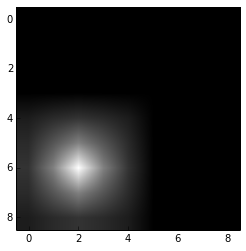

In [121]:
print disp
plt.imshow(test6,cmap='gray')

In [104]:
test

[(-4, 4), (-2, 2), (-3, 3)]

In [241]:
tf.reset_default_graph()


## Training code below is adapted from https://github.com/awjuliani/DeepRL-Agents

### Experience Replay

In [452]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [453]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [454]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 1000000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 5000 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn/piaget" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [457]:
tf.reset_default_graph()

mainQN = protoQnetwork(h_size, mover_prototypes, \
                       mover_disps, 5, 'mainQN')
targetQN = protoQnetwork(h_size, mover_prototypes, \
                       mover_disps, 5, 'targetQN')

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

sess = tf.Session()
#with tf.Session() as sess:
sess.run(init)
if load_model == True:
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)

updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
for i in range(num_episodes):
    episodeBuffer = experience_buffer()
    #Reset environment and get first new observation(s)
    s_list, r, d, info = initial_obs(env)
    s_stack = np.dstack(s_list)
    s = processState(s_stack)

    d = False
    rAll = 0
    j = 0

    # periodically evaluate
    if i % 100 == 0 and i  > 0:
        eval_episode = True
        saved_e = e
        e = 0.05
    else:
        eval_episode = False
    #The Q-Network
    while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
        j+=1
        #Choose an action by greedily (with e chance of random action) from the Q-network
        if np.random.rand(1) < e or total_steps < pre_train_steps:
            a = np.random.randint(0,env.action_space.n)
        else:
            a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
        s_next,r,d,info = env.step(a)
        #s_next = cv2.cvtColor(s_next, cv2.COLOR_BGR2GRAY)

        s_list.pop(0)
        s_list.append(s_next)

        s_stack = np.dstack(s_list)
        s1 = processState(s_stack)

        total_steps += 1
        episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.

        if total_steps > pre_train_steps and not eval_episode:
            if e > endE:
                e -= stepDrop

            if total_steps % (update_freq) == 0:
                trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                #Below we perform the Double-DQN update to the target Q-values
                Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                #Update the network with our target values.
                _ = sess.run(mainQN.updateModel, \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})

                updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
        rAll += r
        s = s1

        if d == True:
            break
    #print(j)
    if not eval_episode:
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
    else:
        print("Evaluated model")
        print(j, rAll)
        e = saved_e
    #Periodically save the model. 
    if i % 100 == 0:
        saver.save(sess,path+'/model-'+str(i)+'.cptk')
        print("Saved Model")
    if len(rList) % 10 == 0:
        print(total_steps,np.mean(rList[-10:]), e)
saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

KeyboardInterrupt: 

### Some tests and visualizations

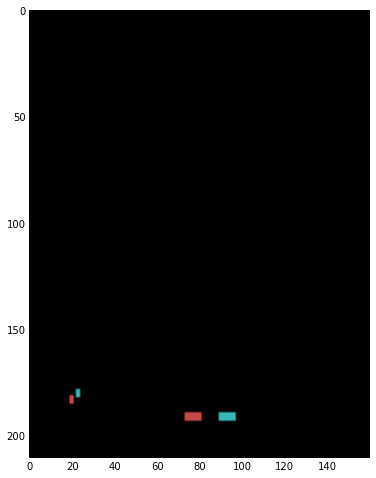

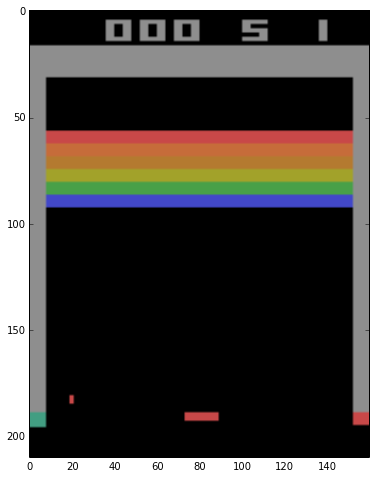

In [390]:
plt.figure(figsize=(12,8))
plt.imshow(s_stack[:,:,3:]-s_stack[:,:,:3])
plt.figure(figsize=(12,8))
plt.imshow(s_stack[:,:,3:])

In [421]:
all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

test_kernel=[v for v in all_vars \
 if v.name == 'mainQN/piaget/mover_disps/mover0/disp2/kernel:0'][0]\
.eval(session=sess)

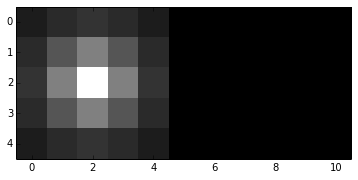

In [423]:
plt.imshow(test_kernel[:,:,0,0],cmap='gray',interpolation='nearest')

In [323]:
test_weights=all_vars[4].eval(session=sess)
test_kernel=all_vars[0].eval(session=sess)

In [280]:
test_weights.shape

(8, 8, 4, 32)

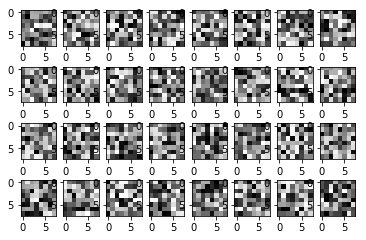

In [323]:
i_max=4
j_max=8
for i in range(i_max):
    for j in range(j_max):
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.imshow(test_weights[:,:,0,j+(i*j_max)],cmap='gray')

In [427]:
t=mt.frame_pairs[3]
s_stack = np.dstack([t.s0,t.s1])
s = processState(s_stack)

mt.movers[0].trajectory

[[2, (86-104, 188-194)],
 [3, (80-98, 188-194)],
 [4, (87-105, 188-194)],
 [5, (85-103, 188-194)],
 [6, (79-97, 188-194)],
 [7, (64-82, 188-194)],
 [8, (52-70, 188-194)],
 [9, (49-67, 188-194)],
 [10, (59-77, 188-194)]]

In [428]:
c0=sess.run(mainQN.conv_movers,feed_dict={mainQN.scalarInput:[s]})
c1=sess.run(mainQN.conv_disps,feed_dict={mainQN.scalarInput:[s]})

In [436]:
[(i, np.max(c1[0,:,:,i])) for i in range(10)]

[(0, 0.34020829),
 (1, 0.045104146),
 (2, 0.045104146),
 (3, 0.045104146),
 (4, 0.045104146),
 (5, 0.045104146),
 (6, 0.15662625),
 (7, 0.022969753),
 (8, 0.022969753),
 (9, 0.15945461)]

(-3, 3)


<matplotlib.colorbar.Colorbar instance at 0x16313ab48>

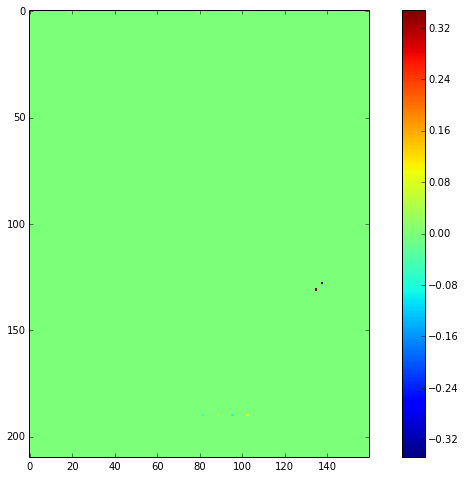

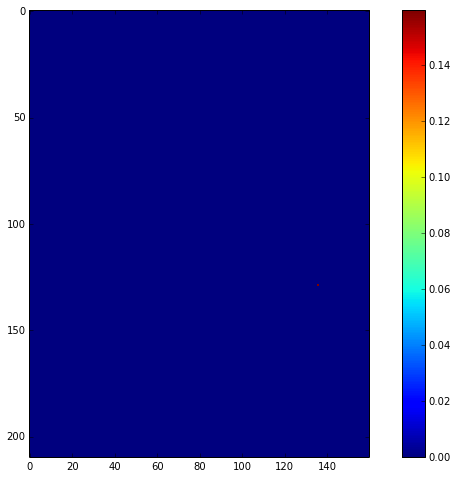

In [438]:
index=9
print(test[index])
plt.figure(figsize=(12,8))
plt.imshow(c0[0,:,:,3]-c0[0,:,:,2],interpolation='nearest')
plt.colorbar()
plt.figure(figsize=(12,8))
plt.imshow(c1[0,:,:,index],interpolation='nearest')
plt.colorbar()

In [292]:
test = reduce(lambda a,b: a+b, mover_disps)
test

[(7, 0),
 (-2, 0),
 (-6, 0),
 (-15, 0),
 (-3, 0),
 (-12, 0),
 (10, 0),
 (-4, 4),
 (-2, 2),
 (-3, 3)]

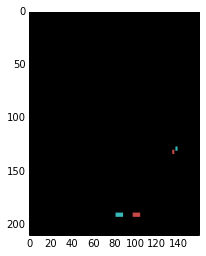

In [435]:
plt.imshow(s_stack[:,:,3:]-s_stack[:,:,:3])

### Checking network learning

Mean reward over time

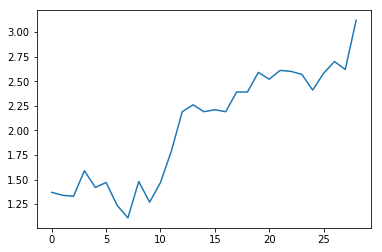

In [36]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)